In [1]:
apikey= 'SEDcFR325HFEwsxuz'
apisecretkey= 'SEDcFR325HFEwsxuzSEDcFR325HFEwsxuzSEDcFR325HFEwsxuz'
accesstoken='126SEDcFR325HFEwsxuzbLHXKSEDcFR325HFEwsxuz6m56xlvGSEDcFR325HFEwsxuz'
accesstokensecret='JS1SEDcFR325HFEwsxuzTCsX6g8JpLzFA5SEDcFR325HFEwsxuzD'


In [2]:
import os
import tweepy as tw

auth = tw.OAuthHandler(apikey, apisecretkey)
auth.set_access_token(accesstoken, accesstokensecret)

api = tw.API(auth,wait_on_rate_limit=True)

In [3]:
import pandas as pd
def extract_timeline_as_df(timeline_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in timeline_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"user": status.user.screen_name, "author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append("user")
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [4]:
#1: What's on MY timeline
my_timeline = api.home_timeline()
df2 = extract_timeline_as_df(my_timeline)
df2.head(3)

,in_reply_to_status_id_str,in_reply_to_screen_name,source,in_reply_to_user_id_str,id_str,source_url,quoted_status_id_str,quoted_status_id,retweet_count,lang,favorite_count,text,in_reply_to_status_id,id,in_reply_to_user_id,user,author
0,NaN,NaN,TweetDeck,NaN,1597994363782680577,https://about.twitter.com/products/tweetdeck,NaN,NaN,2,en,7,#NewsAtNine \n\nIndia to formally take over G-...,NaN,1597994363782680577,NaN,airnewsalerts,airnewsalerts
1,NaN,NaN,Twitter Web App,NaN,1597993734011879426,https://mobile.twitter.com,1597989278172184585,1.597989e+18,5,en,31,"""What do you say to people who think you're a ...",NaN,1597993734011879426,NaN,kelseyhightower,kelseyhightower
2,NaN,NaN,TweetDeck,NaN,1597993075284258817,https://about.twitter.com/products/tweetdeck,NaN,NaN,3,en,21,India to formally take over G-20 Presidency to...,NaN,1597993075284258817,NaN,airnewsalerts,airnewsalerts


In [5]:
#2: What's on different user's timeline
user = api.get_user("JioMart")#JioMart
user_timeline = user.timeline()
df3 = extract_timeline_as_df(user_timeline)
df3.head(2)

,in_reply_to_status_id_str,in_reply_to_screen_name,source,in_reply_to_user_id_str,id_str,source_url,retweet_count,lang,favorite_count,text,in_reply_to_status_id,id,in_reply_to_user_id,user,author
0,NaN,NaN,Twitter Web App,NaN,1597930948816822273,https://mobile.twitter.com,0,en,0,"How to stop thinking about food, can someone H...",NaN,1597930948816822273,NaN,JioMart,JioMart
1,1597850064604778496,JioMart,Twitter Web App,1265286709513773057,1597926411180081154,https://mobile.twitter.com,0,en,0,All Hail the Queen of rice\nBASMATI,1.597850e+18,1597926411180081154,1.265287e+18,JioMart,JioMart


In [6]:
#3 Find all followers and friends count
user = api.get_user("JioMart")
print(user.followers_count, user.friends_count)

25021 8


In [7]:
#4 #following
user_friends = user.friends()
for friend in user_friends:
  print(friend.screen_name)

relianceindltd
Olacabs
IndiaWeatherMan
RelianceDigital
SMARTStores_IN
SupermarketWala
RelianceFreshIN
JioMart_Support


In [8]:
#5: My "Tweets & replies"
import tweepy
for i, status in enumerate(tweepy.Cursor(api.home_timeline, count=5).items(4)):
    print(i, status.text)

0 #NewsAtNine 

India to formally take over G-20 Presidency tomorrow; Several events to be held across the country; 1… https://t.co/wu6hvQmf3j
1 "What do you say to people who think you're a one trick pony?"

I've been a one trick pony my whole career. At one… https://t.co/HR3Qh4Hde8
2 India to formally take over G-20 Presidency tomorrow; 100 monuments to be illuminated with #G20 logo.

Theme honour… https://t.co/xl0NJUVZda
3 NDTV's Ravish Kumar resigns.

Tap the link for details.

#RavishKumar #NDTV

https://t.co/4FSJUKP8Vq


In [9]:
#6_1 - Retrieve Tweets
from textblob import TextBlob
public_tweets = api.search('JioMart')

for tweet in public_tweets:
    print(tweet.text)
    
    #Step 4 Perform Sentiment Analysis on Tweets
    analysis = TextBlob(tweet.text)
    print(analysis.sentiment)
    print("")

@JioMart_Support Boss, no one want to return product for the heck of it, pdt is different from description. returns… https://t.co/T3hQLNxA7S
Sentiment(polarity=0.0, subjectivity=0.6)

RT @suganthagokul: @JioMart @JioMart_Support @reliancegroup  @AmbaniTina  my money stick with jiomart while they declined order. No resolut…
Sentiment(polarity=0.0, subjectivity=0.0)

RT @ram02703677: HELP
I ordered google chrmecast 3 from flipkart.  Whose price is 1999rs.  Not working properly.  But flipkart is neither t…
Sentiment(polarity=0.0, subjectivity=0.1)

@JioMart @JioMart_Support @reliancegroup  @AmbaniTina  my money stick with jiomart while they declined order. No re… https://t.co/yptSDbOODJ
Sentiment(polarity=0.0, subjectivity=0.0)

RT @PandayShashank: @JioMart No refund till now… https://t.co/SQ7p8hg0yg
Sentiment(polarity=0.0, subjectivity=0.0)

HELP
I ordered google chrmecast 3 from flipkart.  Whose price is 1999rs.  Not working properly.  But flipkart is ne… https://t.co/FbFE3rw3C8
Sentime

In [10]:
#6_1: Track hashtag from any date
!pip install -q snscrape
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks/POC_Projects/'

from datetime import date, timedelta
today = date.today()
end_date = today

search_term = 'JioMart'
from_date = date.today() - timedelta(days=10)# '2022-08-28'

os.system(f"snscrape --since {from_date} twitter-search '{search_term} until:{end_date}' > Date_Range_tweets.txt") #will take more than 10 minutes
if os.stat("Date_Range_tweets.txt").st_size == 0:
  counter = 0
else:
  df = pd.read_csv('Date_Range_tweets.txt', names=['link'])
  counter = df.size

print('Number Of Tweets : '+ str(counter))

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/POC_Projects
Number Of Tweets : 5379


In [11]:
#6_1_Extracting Exact Tweeets -- may take 4 to 5 mins
max_results = 5383 #add the number as per ABOVE 'Number Of Tweets'
extracted_tweets = "snscrape --format '{content!r}'"+ f" --max-results {max_results} --since {from_date} twitter-search '{search_term} until:{end_date}' > Date_Range_tweets.txt"

# extracted_tweets = (re.sub('@[a-z,_,A-Z,0-9,:]+ ', '', i) for i in extracted_tweets)

os.system(extracted_tweets)
if os.stat("Date_Range_tweets.txt").st_size == 0:
  print('No Tweets found')
else:
  df = pd.read_csv('Date_Range_tweets.txt', names=['content'])
  for row in df['content'].iteritems():
    print(row)

Streaming output truncated to the last 5000 lines.
(379, "'@JioMart Now many orders placed started canceling or replaced by unwanted products mainly marketed by reliance retail. How can we rely on your service. Better to rely on local vendors.'")
(380, "'@Ashwani99Singh Hi Ashwani")
(381, "'@muneerranghad59 Team JioMart\\u200b (2/2)'")
(382, "'@muneerranghad59 Hi Mateen")
(383, "'@nita_ambani01 @JioMart_Support Hello Mam..just to inform how Big theft is going on ground level in jio mart Grocery delivery . I am senior manager in IT company and customer from 2 years.This time 18 product missing of 2k and look like your mgmt distributing money themself'")
(384, "'@JioMart_Support Broken item received and representative denied for the replacement or replacement. Pathetic service.'")
(385, "'@JioMart_Support @JiomartDigital1 @JioMart Jab bhi https://t.co/ipevy6chsJ mai call krta hu ki order kyu cancel ho rha to bolte hai ki technical issue k chalte cancel ho rha hai")
(386, "'@JioMart_Suppo

In [12]:
#6: Track hashtag from any date
search_words = ["#JioMart"]
date_since = "2022-11-01"

tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items() # limit the count using e.g. .items(5)

tweets

tweet_details = [[tweet.geo, tweet.text,tweet.user.screen_name, tweet.user.location,tweet.created_at,[e['text'] for e in tweet._json['entities']['hashtags']], tweet.user.followers_count] for tweet in tweets]
# tweet_details

import pandas as pd
tweet_df = pd.DataFrame(data=tweet_details, columns=['geo','text','user', "location","Timestamp","All_hashtags","Followers_Count"])

pd.set_option('max_colwidth', 80)
tweet_df.head(5)

,geo,text,user,location,Timestamp,All_hashtags,Followers_Count
0,None,RT @FederalBankLtd: 10% cashback at @JioMart using Federal Bank Debit/ Credi...,GUDDUMA39200350,,2022-11-30 15:26:23,[],24
1,None,Hey @JioMart \nLess number of products are available in our area. Maximum pr...,SarthakNageshw7,,2022-11-30 15:03:43,[],10
2,None,RT @FederalBankLtd: 10% cashback at @JioMart using Federal Bank Debit/ Credi...,akhileshsinger9,"Lucknow, India",2022-11-30 12:52:18,[],588
3,None,"How to stop thinking about food, can someone HELP? 😫\n\n#JioMart https://t.c...",JioMart,,2022-11-30 12:30:00,[JioMart],25022
4,None,RT @FederalBankLtd: 10% cashback at @JioMart using Federal Bank Debit/ Credi...,guatam_mayank,,2022-11-30 11:17:06,[],51


In [13]:
#7: User's count who tweeted
tweet_df.user.value_counts()

abhimani2002     16
JioMart          14
YakshuGarg       10
tripathy009       7
santukr3          4
                 ..
ZamilAkh          1
BaqaiSabirali     1
SakethNannaka     1
trilokesh612      1
wwwPoet           1
Name: user, Length: 84, dtype: int64

In [14]:
#8: Tweeted from location
tweet_df.location.value_counts()

                            77
Mumbai, Maharashtra         16
New Delhi, India             6
India                        6
New Delhi                    4
Varanasi, India              3
Sagar, MP                    3
Gurgaon                      3
Jabalpur, Madhya Pradesh     2
Bengaluru, India             2
Hyderabad, India             2
Lucknow, India               2
indore                       2
Sunam                        1
Metaverse                    1
Vododara, India              1
फ़तेहाबाद, भारत              1
World                        1
Cochin, India                1
Delhi, India                 1
Surat, India                 1
Kerala, India                1
Mumbai, India                1
Kota, India                  1
Bhubaneswar Odisha           1
Mumbai                       1
Kadi, India                  1
Karol bagh, Delhi, India     1
Jaipur, Rajasthan, India     1
Pune, India                  1
Chhattisgarh India           1
The web                      1
Name: lo

In [15]:
#9: Save csv file after data cleaning
import re
def clean_tweets(text):
    text = re.sub("RT @[\w]*:","",text)
    text = re.sub("@[\w]*","",text)
    text = re.sub("https?://[A-Za-z0-9./]*","",text)
    text = re.sub("\n","",text)


    text = re.sub("\$\w*","",text)
    text = re.sub("^RT[\s]+","",text)
    text = re.sub("https?:\/\/.*[\r\n]*","",text)
    text = re.sub("#","",text)

    return text

tweet_df['text']=tweet_df['text'].apply(lambda x: clean_tweets(x))

# tweet_df.head(20)
tweet_df.to_csv('Hashed_tweets.csv') #check file in right side folder
# !ls

In [16]:
#10 SENTIMENT ANALYSIS
import spacy
nlp = spacy.load('en_core_web_sm')

tweet_df['text'].apply(lambda x: [print("\tText : {}, Entity : {}".format(ent.text, ent.label_)) if (not ent.text.startswith('#')) else ""  for ent in nlp(x).ents])


	Text : 10%, Entity : PERCENT
	Text : Federal Bank Debit/ Credit, Entity : ORG
	Text : 30th Nov 2022.Know, Entity : DATE
	Text : https:/, Entity : CARDINAL
	Text : 10%, Entity : PERCENT
	Text : Federal Bank Debit/ Credit, Entity : ORG
	Text : 30th Nov 2022.Know, Entity : DATE
	Text : https:/, Entity : CARDINAL
	Text : HELP, Entity : ORG
	Text : JioMart, Entity : PERSON
	Text : 10%, Entity : PERCENT
	Text : Federal Bank Debit/ Credit, Entity : ORG
	Text : 30th Nov 2022.Know, Entity : DATE
	Text : https:/, Entity : CARDINAL
	Text : nhi hota, Entity : ORG
	Text : jiomart, Entity : ORG
	Text : Param Ghee: Fresh, Entity : PERSON
	Text : Param Ghee, Entity : GPE
	Text : Jasmine, Entity : PERSON
	Text : Basmati, Entity : ORG
	Text : Arborio, Entity : GPE
	Text : PatheticService, Entity : ORG
	Text : 10%, Entity : PERCENT
	Text : Federal Bank Debit/ Credit, Entity : ORG
	Text : 30th Nov 2022.Know, Entity : DATE
	Text : https:/, Entity : CARDINAL
	Text : Jiomart, Entity : ORG
	Text : 10%, Entit

0      [None, None, None, None]
1                            []
2      [None, None, None, None]
3                  [None, None]
4      [None, None, None, None]
                 ...           
142                      [None]
143          [None, None, None]
144          [None, None, None]
145                      [None]
146          [None, None, None]
Name: text, Length: 147, dtype: object

In [17]:

tweet_df['entities']=tweet_df['text'].apply(lambda x: [(ent.text, ent.label_) if (not ent.text.startswith('#')) else "" for ent in nlp(x).ents])
print(tweet_df.head(5))

    geo  \
0  None   
1  None   
2  None   
3  None   
4  None   

                                                                              text  \
0   10% cashback at  using Federal Bank Debit/ Credit cards!Offer valid till 30...   
1  Hey  Less number of products are available in our area. Maximum products are...   
2   10% cashback at  using Federal Bank Debit/ Credit cards!Offer valid till 30...   
3                     How to stop thinking about food, can someone HELP? 😫JioMart    
4   10% cashback at  using Federal Bank Debit/ Credit cards!Offer valid till 30...   

              user        location           Timestamp All_hashtags  \
0  GUDDUMA39200350                 2022-11-30 15:26:23           []   
1  SarthakNageshw7                 2022-11-30 15:03:43           []   
2  akhileshsinger9  Lucknow, India 2022-11-30 12:52:18           []   
3          JioMart                 2022-11-30 12:30:00    [JioMart]   
4    guatam_mayank                 2022-11-30 11:17:06       

In [18]:
#7: NER
import nltk
nltk.download('punkt')

from nltk import ne_chunk
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
def ner_tweets(text):
  ne_token =word_tokenize(text)
  ne_tags = nltk.pos_tag(ne_token)

  ne_ner = ne_chunk(ne_tags)
  return ne_ner

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [19]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

tweet_df['sentiment']=tweet_df['text'].apply(lambda x: sid.polarity_scores(x))
tweet_df['NER_1']=tweet_df['text'].apply(lambda x: [(ent.text,ent.start_char, ent.end_char, ent.label_) if (not ent.text.startswith('#')) else "" for ent in nlp(x).ents])
tweet_df['NER_2']=tweet_df['text'].apply(lambda x: ner_tweets(x))


tweet_df.to_csv('FINAL.csv')
tweet_df.head(10) #sentiment is added

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,geo,text,user,location,Timestamp,All_hashtags,Followers_Count,entities,sentiment,NER_1,NER_2
0,None,10% cashback at using Federal Bank Debit/ Credit cards!Offer valid till 30...,GUDDUMA39200350,,2022-11-30 15:26:23,[],24,"[(10%, PERCENT), (Federal Bank Debit/ Credit, ORG), (30th Nov 2022.Know, DAT...","{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'compound': 0.4389}","[(10%, 1, 4, PERCENT), (Federal Bank Debit/ Credit, 24, 50, ORG), (30th Nov ...","[(10, CD), (%, NN), (cashback, NN), (at, IN), (using, VBG), [(Federal, NNP),..."
1,None,Hey Less number of products are available in our area. Maximum products are...,SarthakNageshw7,,2022-11-30 15:03:43,[],10,[],"{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'compound': 0.0018}",[],"[[(Hey, NNP)], [(Less, NNP)], (number, NN), (of, IN), (products, NNS), (are,..."
2,None,10% cashback at using Federal Bank Debit/ Credit cards!Offer valid till 30...,akhileshsinger9,"Lucknow, India",2022-11-30 12:52:18,[],588,"[(10%, PERCENT), (Federal Bank Debit/ Credit, ORG), (30th Nov 2022.Know, DAT...","{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'compound': 0.4389}","[(10%, 1, 4, PERCENT), (Federal Bank Debit/ Credit, 24, 50, ORG), (30th Nov ...","[(10, CD), (%, NN), (cashback, NN), (at, IN), (using, VBG), [(Federal, NNP),..."
3,None,"How to stop thinking about food, can someone HELP? 😫JioMart",JioMart,,2022-11-30 12:30:00,[JioMart],25022,"[(HELP, ORG), (JioMart, PERSON)]","{'neg': 0.161, 'neu': 0.587, 'pos': 0.252, 'compound': 0.3034}","[(HELP, 45, 49, ORG), (JioMart, 52, 59, PERSON)]","[(How, WRB), (to, TO), (stop, VB), (thinking, VBG), (about, IN), (food, NN),..."
4,None,10% cashback at using Federal Bank Debit/ Credit cards!Offer valid till 30...,guatam_mayank,,2022-11-30 11:17:06,[],51,"[(10%, PERCENT), (Federal Bank Debit/ Credit, ORG), (30th Nov 2022.Know, DAT...","{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'compound': 0.4389}","[(10%, 1, 4, PERCENT), (Federal Bank Debit/ Credit, 24, 50, ORG), (30th Nov ...","[(10, CD), (%, NN), (cashback, NN), (at, IN), (using, VBG), [(Federal, NNP),..."
5,None,itne bekar or ghatiya app koi bhi solution nhi hota replace se sambandhit...,Sandeep5170,,2022-11-30 09:15:33,[],0,"[(nhi hota, ORG)]","{'neg': 0.0, 'neu': 0.867, 'pos': 0.133, 'compound': 0.3182}","[(nhi hota, 46, 54, ORG)]","[(itne, JJ), (bekar, NN), (or, CC), (ghatiya, NN), (app, NN), (koi, NN), (bh..."
6,None,jiomart is a fr…,abhimani2002,"Mumbai, Maharashtra",2022-11-30 08:29:12,[jiomart],189,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",[],"[(jiomart, NN), (is, VBZ), (a, DT), (fr…, NN)]"
7,None,jiomart is a fraud we…,abhimani2002,"Mumbai, Maharashtra",2022-11-30 08:29:09,[jiomart],189,[],"{'neg': 0.559, 'neu': 0.441, 'pos': 0.0, 'compound': -0.5859}",[],"[(jiomart, NN), (is, VBZ), (a, DT), (fraud, NN), (we…, NN)]"
8,None,jiomart i…,abhimani2002,"Mumbai, Maharashtra",2022-11-30 08:28:53,[jiomart],189,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",[],"[(jiomart, NN), (i…, NN)]"
9,None,jiomart is a fr…,abhimani2002,"Mumbai, Maharashtra",2022-11-30 08:25:20,[jiomart],189,"[(jiomart, ORG)]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}","[(jiomart, 0, 7, ORG)]","[(jiomart, NN), (is, VBZ), (a, DT), (fr…, NN)]"


In [20]:
#11: Export csv file as per inputted hashtag
import json
import csv
import tweepy
def search_for_hashtags(apikey, apisecretkey, accesstoken, accesstokensecret, hashtag_phrase):
    #create authentication for accessing Twitter
    auth = tweepy.OAuthHandler(apikey, apisecretkey)
    auth.set_access_token(accesstoken, accesstokensecret)

    #initialize Tweepy API
    api = tweepy.API(auth)
    
    #get the name of the spreadsheet we will write to
    fname = ''.join(re.findall(r"#(\w+)", hashtag_phrase))

    #open the spreadsheet we will write to
    with open('%s 2_tweets.csv' % (fname), 'w') as file:

      w = csv.writer(file)

      #write header row to spreadsheet
      w.writerow(['timestamp', 'tweet_text', 'username', 'all_hashtags', 'followers_count'])

      #for each tweet matching our hashtags, write relevant info to the spreadsheet
      for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', lang="en", tweet_mode='extended').items(10):
        w.writerow([tweet.created_at, tweet.full_text.replace('\n',' ').encode('utf-8'), tweet.user.screen_name.encode('utf-8'), [e['text'] for e in tweet._json['entities']['hashtags']], tweet.user.followers_count])
            


# hashtag_phrase = input('Hashtag Phrase: ') ##FIFAWorldCup
hashtag_phrase = 'FIFAWorldCup' ##FIFAWorldCup
if __name__ == '__main__':
  search_for_hashtags(apikey, apisecretkey, accesstoken, accesstokensecret, hashtag_phrase)

In [21]:
#12: Reply any tweet
# og_tweet = api.get_status("1584907651753746432")
# # print(og_tweet.user.screen_name, og_tweet.id)
# my_reply = api.update_status(f"@{og_tweet.user.screen_name} Wow this cool!", og_tweet.id)
#print(my_reply.id, my_reply.user.screen_name)

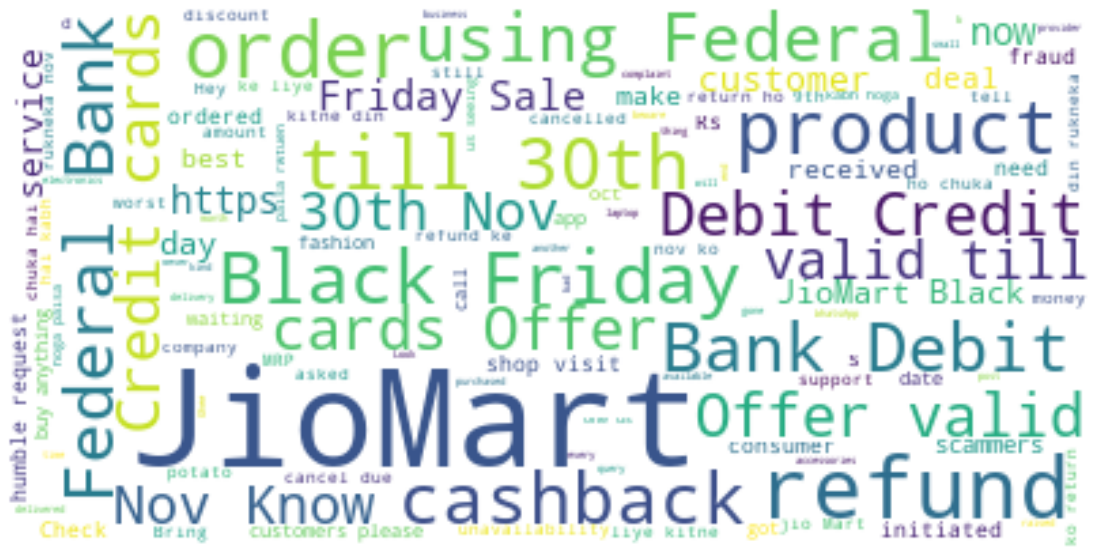

<Figure size 432x288 with 0 Axes>

In [22]:
#13: Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
text = " ".join(review for review in tweet_df.text)
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=50, max_words=1000,background_color="white",contour_width=3, contour_color='firebrick').generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# store to file
plt.savefig("WC.png", format="png")